# Training the agent

This cell contains the training loop for the present smart agent. See **report.md** for details.

This cell has been ran a second time to provide a clear formated output. However the simulation can be ran from scratch by commenting the weight loading (line 35) to see how the agent learns.

In [1]:
from agent import agent
from unityagents import UnityEnvironment
import numpy as np
import torch

# Hyperparameters
eps = 0.75 # Initial probability to chose a random action for exploration
epsDecay = 0.99 # decay by episode
minEps = 0.01 # minimum epsilon

printEvery = 10 # To follow the score online while training

# Penalty when the agent makes a no-banana move (avoid the agent to isolate in safe corners)
noBananaPenalty = -0.05 

env = UnityEnvironment(file_name="../Banana_Linux/Banana.x86_64")
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)

# Agent creation
# This agent has 2 hidden layers with 64 nodes
myAgent = agent.agent(state_size, action_size, n_nodes_hlayers=64, seed = 42)
myAgent.learningRate = 2.5e-4  # Setting the learning rate for Adam optimization

score = 0
scoreList = []
n_episodes = 0 # number of stored episodes
#Loading model weights to restart previous optimization
myAgent.qnetwork_local.load_state_dict(torch.load('best_model.pth')) 
while(True):
    # reset the environment for new episode
    env_info = env.reset(train_mode=True)[brain_name]
    
    while True:
        action = myAgent.act(state, eps)               # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        score += reward                                # update the score
        # We slightly modify the reward giving a penalty to passive moves (no banana - yellow or blue - collected)
        if np.abs(reward) > 0.1:
            myReward = reward
        else:
            myReward = noBananaPenalty # give a penalty 
        myAgent.step(state, action, myReward, next_state, done)  # Agent next move and training
        if done:                                       # exit loop if episode finished
            break
        state = next_state                             # roll over the state to next time step

    if (n_episodes > 100) and (n_episodes % printEvery ==0):
        m = np.average(np.array(scoreList)[-100:])
        std = np.std(np.array(scoreList)[-100:])
        print("episode: {:3d} - Score: {:2d} - Average over last 100 scores: {:.2f} +- {:.2f}".format(n_episodes,int(score), m, std), end="\r")
        
        
    scoreList.append(score)
    
    # Updating epsilon
    eps *= epsDecay
    eps = max(eps, minEps)
    
    n_episodes += 1
    # Stop training if 100 consecutive episodes score > 13.1 (should be replaced by an easier condition)
    if (n_episodes > 500):
        break
        if np.min(np.array(scoreList)[-100:]) > 13.1:
            break
    score = 0
    
print("\nLast score: {}".format(score))
print("Average over last 100 scores: {}".format(np.average(np.array(scoreList)[-100:])))
env.close() # Closing the environment

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


episode: 500 - Score: 17 - Average over last 100 scores: 15.94 +- 3.57
Last score: 17.0
Average over last 100 scores: 15.98


## Agent evaluation

We load the Numpy array of scores during the first run of optimization (from scratch: the agent did not collect any experience). In the cell below we find the first moment where the agent achieved an average score > 13 over 100 consecutive episodes.

In [23]:
import numpy as np
scoreList = np.load("scoreListe.npy")

solved = np.argmax(np.array([np.average(scoreList[i:i+100]) for i in range(len(scoreList) - 100)]) > 13) + 1
print("The agent solved the problem after {} episodes.".format(solved))

The agent solved the problem after 318 episodes.


## Plot of the scores



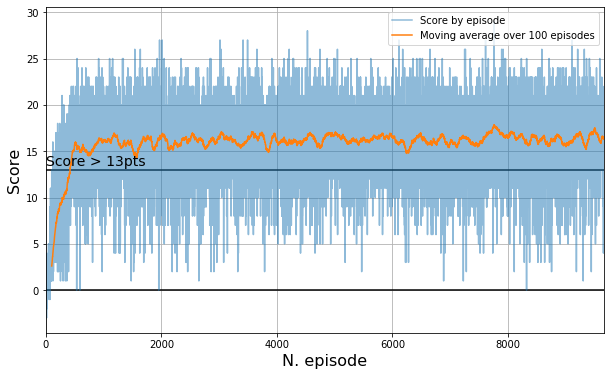

In [6]:
import matplotlib.pyplot as plt
import numpy as np
scoreList = np.load("scoreListe.npy")
figure = plt.figure(figsize=(10,6))

plt.xlabel("N. episode", fontsize = 16)
plt.ylabel("Score", fontsize = 16)
plt.grid()
plt.xlim((0,len(scoreList)))
plt.hlines(0,0, len(scoreList))
plt.hlines(13,0, len(scoreList))
plt.text(5., 13.5, "Score > 13pts", fontsize=14)
plt.plot(scoreList, label="Score by episode", alpha = 0.5)
rollingMean = np.array( [np.average(scoreList[i:i+100]) for i in range(len(scoreList) - 100)])
plt.plot(range(100, len(rollingMean)+100) ,rollingMean, label = "Moving average over 100 episodes" )
plt.legend(loc = 1)
plt.show()

In [3]:
# Saving the weights
import torch
torch.save(myAgent.qnetwork_local.state_dict(), 'checkpoint.pth')

In [4]:
np.save("scoreListe.npy", np.array(scoreList))

In [ ]:
# Observing the trained agent
from agent import agent
import torch
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=False)[brain_name] # reset the environment

action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)
myAgent = agent.agent(state_size, action_size, n_nodes_hlayers=64, seed = 22)

# load the weights from file
myAgent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
eps = 0.
score = 0                                          # initialize the score
while True:
    action = myAgent.act(state, eps)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))
env.close()